<a href="https://colab.research.google.com/github/multimediary/portfolio-data-science/blob/main/fraud-modeling-CDR-K-Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. IMPORT LIBRARY**

In [2]:
# For ignore warning
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Library For code execution time
!pip install ipython-autotime
%load_ext autotime

# Library For Preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler

# Library For Clustering
from sklearn.cluster import KMeans

# Library For Visualization
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Library For Evaluation
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.64 s (started: 2021-04-11 13:06:57 +00:00)


**2. DATA GATHERING**

In [3]:
# Read Dataset with Pandas from Git
df = pd.read_csv("https://raw.githubusercontent.com/multimediary/dataset/master/cdrwithfraude.csv")
df.head()

,starttime,stoptime,anumber,bnumber,duration,fee,destination,type,label
0,2018-05-02 09:13:24,2018-05-02 09:20:38,778692960,1500200,434,6000,callcenter,Injapati,0
1,2018-05-18 16:49:19,2018-05-18 16:52:11,778692960,1500200,172,2250,callcenter,Injapati,0
2,2018-05-18 18:15:17,2018-05-18 18:18:20,778692960,1500200,183,3000,callcenter,Injapati,0
3,2018-05-31 08:52:46,2018-05-31 08:53:03,778692253,1500788,17,750,callcenter,Injapati,0
4,2018-05-31 08:53:10,2018-05-31 08:53:24,778692253,1500788,14,750,callcenter,Injapati,0


time: 423 ms (started: 2021-04-11 13:07:28 +00:00)


In [4]:
# Show Dataset Description (Focus at Dtype)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11418 entries, 0 to 11417
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   starttime    11418 non-null  object
 1   stoptime     11418 non-null  object
 2   anumber      11418 non-null  int64 
 3   bnumber      11418 non-null  object
 4   duration     11418 non-null  int64 
 5   fee          11418 non-null  int64 
 6   destination  11418 non-null  object
 7   type         11418 non-null  object
 8   label        11418 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 803.0+ KB
time: 28.5 ms (started: 2021-04-11 13:07:50 +00:00)


In [5]:
# Displays Dataframe Statistics (Focus at std)
df.describe()

,anumber,duration,fee,label
count,1.141800e+04,11418.000000,1.141800e+04,11418.000000
mean,7.786475e+08,154.111841,1.215145e+04,0.034770
std,3.985148e+04,410.204092,4.131463e+04,0.183204
min,7.786101e+08,0.000000,4.300000e+01,0.000000
25%,7.786133e+08,24.000000,6.340000e+02,0.000000
50%,7.786134e+08,57.000000,2.614000e+03,0.000000
75%,7.786930e+08,143.000000,1.045400e+04,0.000000
max,7.786978e+08,17735.000000,1.567841e+06,1.000000


time: 31 ms (started: 2021-04-11 13:08:07 +00:00)


In [6]:
# Show dataset shape
df.shape

(11418, 9)

time: 3.48 ms (started: 2021-04-11 13:08:27 +00:00)


In [7]:
# Show the dataset labeled fraud (1) and non fraud (0)
df['label'].value_counts()

0    11021
1      397
Name: label, dtype: int64

time: 10.5 ms (started: 2021-04-11 13:08:38 +00:00)


In [8]:
# Show a comparison between the dataset labeled fraud and non-fraud
print(df['label'].value_counts() / df['label'].shape[0])

0    0.96523
1    0.03477
Name: label, dtype: float64
time: 29.5 ms (started: 2021-04-11 13:08:49 +00:00)


In [9]:
# Check what types of calls are there
df['type'].value_counts()

SLJJ          7093
SLI 001       4035
Lokal          153
SLI 007        102
VoIP 01017      21
Injapati        14
Name: type, dtype: int64

time: 12.8 ms (started: 2021-04-11 13:08:58 +00:00)


In [10]:
# Find null in the dataset
df.isnull().sum().max()

0

time: 10.8 ms (started: 2021-04-11 13:09:30 +00:00)


**3. DATA PREPARATION**

In [12]:
# Drop unneeded attributes, namely startime and stoptime, destination and label
dataset = df.drop(['starttime','stoptime','destination','label'], axis = 1)
label = df.label

time: 5.51 ms (started: 2021-04-11 13:16:04 +00:00)


In [13]:
enc = LabelEncoder()
def transforming(input, j):
    input.iloc[:,j] = enc.fit_transform(input.iloc[:,j])

# Change data in the form of objects / strings into numbers
for i in range(0,5):
    if(i!=2 or i!=3):
        transforming(dataset, i)

time: 18.1 ms (started: 2021-04-11 13:22:49 +00:00)


In [14]:
# Show Dataset 
dataset.head()

,anumber,bnumber,duration,fee,type
0,265,3236,431,447,0
1,265,3236,172,238,0
2,265,3236,183,294,0
3,225,3237,17,96,0
4,225,3237,14,96,0


time: 12.3 ms (started: 2021-04-11 13:23:01 +00:00)


In [15]:
# Transform data with Scaler to perform data normalization so that the data used does not have large deviations.
features = ['anumber', 'bnumber', 'duration', 'fee', 'type']
Final_Dataset = dataset.loc[:, features].values
Final_Dataset = StandardScaler().fit_transform(Final_Dataset)
Final_Dataset = pd.DataFrame(data = Final_Dataset, columns = features)

time: 14 ms (started: 2021-04-11 13:27:49 +00:00)


In [16]:
# Show the Final Dataset 
Final_Dataset.head()

,anumber,bnumber,duration,fee,type
0,1.097724,1.802827,1.697394,0.358047,-3.259819
1,1.097724,1.802827,0.250598,-0.376284,-3.259819
2,1.097724,1.802827,0.312045,-0.179525,-3.259819
3,0.540323,1.803923,-0.615244,-0.875207,-3.259819
4,0.540323,1.803923,-0.632003,-0.875207,-3.259819


time: 19.9 ms (started: 2021-04-11 13:28:07 +00:00)


In [17]:
# Show Final Dataset Description (Focus at Dtype)
Final_Dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11418 entries, 0 to 11417
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anumber   11418 non-null  float64
 1   bnumber   11418 non-null  float64
 2   duration  11418 non-null  float64
 3   fee       11418 non-null  float64
 4   type      11418 non-null  float64
dtypes: float64(5)
memory usage: 446.1 KB
time: 10.3 ms (started: 2021-04-11 13:28:22 +00:00)


In [18]:
# Displays Final_Dataset Statistics (Focus at std)
Final_Dataset.describe()

,anumber,bnumber,duration,fee,type
count,1.141800e+04,1.141800e+04,1.141800e+04,1.141800e+04,1.141800e+04
mean,-2.250511e-15,1.878959e-15,-6.163206e-16,-7.016049e-15,3.629611e-14
std,1.000044e+00,1.000044e+00,1.000044e+00,1.000044e+00,1.000044e+00
min,-2.595056e+00,-1.743395e+00,-7.102079e-01,-1.212507e+00,-3.259819e+00
25%,-5.048034e-01,-8.346482e-01,-5.761419e-01,-9.314236e-01,-1.248220e+00
50%,-2.121680e-01,-5.083002e-02,-3.918012e-01,-2.849318e-01,7.633788e-01
75%,1.055919e+00,8.822999e-01,8.860188e-02,7.831852e-01,7.633788e-01
max,1.515775e+00,1.806115e+00,4.814428e+00,2.736715e+00,1.769178e+00


time: 37.6 ms (started: 2021-04-11 13:31:26 +00:00)


In [19]:
# Persiapan Dataset
X = Final_Dataset.to_numpy()
y = df.iloc[:, 8] # Label Fraud
y = np.array(y).astype(np.float)

time: 2.75 ms (started: 2021-04-11 13:31:51 +00:00)


In [20]:
X

array([[ 1.09772399,  1.80282727,  1.6973936 ,  0.35804655, -3.25981941],
       [ 1.09772399,  1.80282727,  0.25059827, -0.37628386, -3.25981941],
       [ 1.09772399,  1.80282727,  0.31204517, -0.17952547, -3.25981941],
       ...,
       [ 1.09772399,  1.78967688,  0.64162403,  1.18372906,  1.76917832],
       [ 1.09772399,  1.79077274, -0.69344965, -0.05303794,  1.76917832],
       [ 1.09772399,  1.79077274, -0.67110532, -0.05303794,  1.76917832]])

time: 8.29 ms (started: 2021-04-11 13:31:55 +00:00)


In [21]:
y

array([0., 0., 0., ..., 0., 0., 0.])

time: 3.52 ms (started: 2021-04-11 13:31:58 +00:00)


**4. DATA MODELING WITH K-MEANS**

Kmeans algorithm is an iterative algorithm that tries to partition the dataset into Kpre-defined distinct non-overlapping subgroups (clusters) where each data point belongs to only one group. It tries to make the intra-cluster data points as similar as possible while also keeping the clusters as different (far) as possible. It assigns data points to a cluster such that the sum of the squared distance between the data points and the cluster’s centroid (arithmetic mean of all the data points that belong to that cluster) is at the minimum. The less variation we have within clusters, the more homogeneous (similar) the data points are within the same cluster. (Towards Data Science, 2018)

**Elbow Methode**

Elbow method gives us an idea on what a good k number of clusters would be based on the sum of squared distance (SSE) between data points and their assigned clusters’ centroids. We pick k at the spot where SSE starts to flatten out and forming an elbow. We’ll use the geyser dataset and evaluate SSE for different values of k and see where the curve might form an elbow and flatten out. (Towards Data Science, 2018)

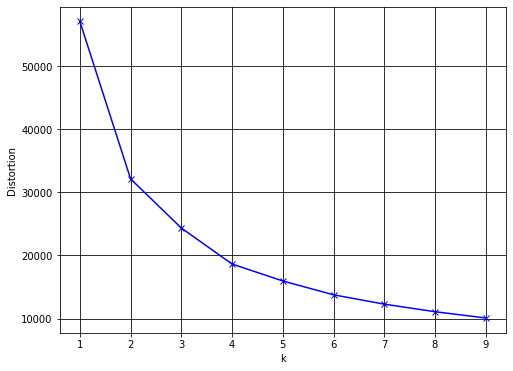

time: 3.08 s (started: 2021-04-11 13:38:21 +00:00)


In [22]:
# Find cluster with Elbow Method
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0)
    kmeanModel.fit(Final_Dataset)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(8,6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.grid(c='black')
#plt.title('The Elbow Method showing the optimal k')
plt.show()

Based on the graph above, we take the K value is 4.

In [23]:
# K-Means parameters
kmeans = KMeans(n_clusters=4, init ='k-means++', max_iter =1000,
                random_state=0, verbose=0, n_init=1).fit(X)

# Get the cluster number for each data point
X_clusters = kmeans.predict(X)

# Save the cluster centroid
X_clusters_centers = kmeans.cluster_centers_

# Calculate the distance to the center of the group for each point
dist = [np.linalg.norm(x-y) for x,y in zip(X, X_clusters_centers[X_clusters])]

# Make predictions based on distance
km_y_pred = np.array(dist)

# If the distance is far, it will be an outlier / fraud
km_y_pred[dist>=np.percentile(dist, 93)] = 1

# If the distance is close, it is not an outlier / non fraud
km_y_pred[dist<np.percentile(dist, 93)] = 0

km_y_pred

array([1., 1., 1., ..., 1., 1., 1.])

time: 179 ms (started: 2021-04-11 14:40:52 +00:00)


In [24]:
# Duplicate Final Dataset and Add Column Labels K-Means
Final_Dataset_copy = Final_Dataset.copy()
Final_Dataset_copy['labels_kmeans'] = km_y_pred

time: 4.18 ms (started: 2021-04-11 14:43:26 +00:00)


In [26]:
# Show Final Dataset Copy plus Labels K-Means 
Final_Dataset_copy.head()

,anumber,bnumber,duration,fee,type,labels_kmeans
0,1.097724,1.802827,1.697394,0.358047,-3.259819,1.0
1,1.097724,1.802827,0.250598,-0.376284,-3.259819,1.0
2,1.097724,1.802827,0.312045,-0.179525,-3.259819,1.0
3,0.540323,1.803923,-0.615244,-0.875207,-3.259819,1.0
4,0.540323,1.803923,-0.632003,-0.875207,-3.259819,1.0


time: 16.6 ms (started: 2021-04-11 14:43:47 +00:00)


In [27]:
# Count Labels
Final_Dataset_copy['labels_kmeans'].value_counts().sort_index()

0.0    10618
1.0      800
Name: labels_kmeans, dtype: int64

time: 9.04 ms (started: 2021-04-11 14:46:31 +00:00)


**5. DATA VISUALIZATION WITH PCA**

In [28]:
plotX = Final_Dataset_copy

time: 1.4 ms (started: 2021-04-11 14:49:44 +00:00)


In [29]:
pca_2d = PCA(n_components=2)

time: 1.05 ms (started: 2021-04-11 14:49:56 +00:00)


In [30]:
PCs_2d = pd.DataFrame(pca_2d.fit_transform(plotX.drop(["labels_kmeans"], axis=1)))

time: 50.6 ms (started: 2021-04-11 14:50:00 +00:00)


In [31]:
PCs_2d.columns = ["PC1_2d", "PC2_2d"]

time: 1.68 ms (started: 2021-04-11 14:50:04 +00:00)


In [32]:
plotX = pd.concat([plotX,PCs_2d], axis=1, join='inner')

time: 4.5 ms (started: 2021-04-11 14:50:15 +00:00)


In [33]:
cluster0 = plotX[plotX["labels_kmeans"] == 0]
cluster1 = plotX[plotX["labels_kmeans"] == 1]

time: 8.55 ms (started: 2021-04-11 14:50:18 +00:00)


In [34]:
init_notebook_mode(connected=True)

time: 5.21 ms (started: 2021-04-11 14:50:21 +00:00)


In [36]:
#trace1 is for 'Cluster 0'
trace1 = go.Scatter(
                    x = cluster0["PC1_2d"],
                    y = cluster0["PC2_2d"],
                    mode = "markers",
                    name = "Non Fraud",
                    marker = dict(color = 'rgba(0, 0, 0, 0.8)'),
                    text = None)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter(
                    x = cluster1["PC1_2d"],
                    y = cluster1["PC2_2d"],
                    mode = "markers",
                    name = "Fraud",
                    marker = dict(color = 'rgba(240, 52, 52, 0.8)'),
                    text = None)

data = [trace1, trace2]

title = "K-Means - PCA"

layout = dict(title = title,
              xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
             )

#Plot and save html
plotly.offline.plot({"data": data,
                     "layout": layout},
                     auto_open=True)

'temp-plot.html'

time: 468 ms (started: 2021-04-11 14:50:49 +00:00)


Download and Open File temp-plot.html to see the Graph, please screenshoot and Place in here.

![](https://github.com/multimediary/portfolio-data-science/blob/main/screenshots/fraud-modeling-CDR-K-Means.jpg?raw=true)

**6. DATA EVALUATION WITH CONFUSION MATRIX**

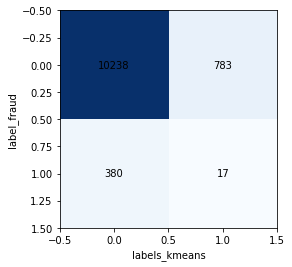

time: 204 ms (started: 2021-04-11 14:55:55 +00:00)


In [37]:
C = confusion_matrix(df["label"],plotX["labels_kmeans"])

# Plot confusion matrix
plt.imshow(C,interpolation='none',cmap='Blues')
for (i, j), z in np.ndenumerate(C):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("labels_kmeans")
plt.ylabel("label_fraud")
plt.show()

In [38]:
print(C)

[[10238   783]
 [  380    17]]
time: 1.31 ms (started: 2021-04-11 14:56:03 +00:00)


In [39]:
# Nilai Accuracy, Precision, Recall, and F1 Score
print("Accuracy Score of K-Means", accuracy_score(df["label"], plotX["labels_kmeans"]))
print("Recall of K-Means", recall_score(df["label"], plotX["labels_kmeans"],average=None, zero_division=1))
print("Precision Score of K-Means", precision_score(df["label"], plotX["labels_kmeans"],average=None, zero_division=1))
print("F1 Score of K-Means", f1_score(df["label"], plotX["labels_kmeans"],average=None, zero_division=1))

Accuracy Score of K-Means 0.8981432825363461
Recall of K-Means [0.92895382 0.04282116]
Precision Score of K-Means [0.96421172 0.02125   ]
F1 Score of K-Means [0.94625445 0.02840434]
time: 29.2 ms (started: 2021-04-11 14:56:06 +00:00)
